# Importing
### Import library

In [3]:
"""Import library""" 
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.applications import ResNet50V2 as ResNet
from tensorflow.keras.callbacks import EarlyStopping,  ReduceLROnPlateau
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

import cv2
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 28)

import random
import os

!pip install imutils
import imutils
from imutils.contours import sort_contours

### Import dataset

In [4]:
def extractImages(datadir):
    # Get the data
    imagesData = []
    imagesLabel = []
    for folder in os.listdir(datadir):
        path = os.path.join(datadir, folder)
        for images in os.listdir(path):
            img = cv2.imread(os.path.join(path, images), cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (32, 32))
            imagesData.append(img)
            imagesLabel.append(folder)
            
    # Shuffle data
    combined = list(zip(imagesData, imagesLabel))
    random.shuffle(combined)
    imagesData, imagesLabel = zip(*combined)
    
    return (imagesData, imagesLabel)

In [5]:
# Import train data
imagesData = []
imagesLabel = []
train_data_dir = 'C:/Users/aryap/OneDrive/Desktop/PYTHON LANGUAGE/Maths_Handwritten_Project/Img_Folder'

imagesData, imagesLabel = extractImages(train_data_dir)

print("number of image: ",len(imagesData))        
print("shape of image:  ",imagesData[1].shape)
print("labels:          ",list(set(imagesLabel)))

number of image:  96429
shape of image:   (32, 32)
labels:           [')', '0', '+', '-', '!', ',', '(']


In [6]:
imagesTrainData, imagesTestData, imagesTrainLabel, imagesTestLabel = train_test_split(
                                                                                    imagesData,imagesLabel, 
                                                                                    shuffle=True, 
                                                                                    test_size=0.2, 
                                                                                    random_state=42,
                                                                                    stratify= imagesLabel )

---
# Data Exploring
### Show Dataset Image

In [7]:
# Show Image
def showImage (images,label,part):
    figure = plt.figure(figsize=((len(part)/10 + 1)*10, (len(part)/10 + 1)*2))
    j = 0
    for i in part:
        lbl = label[i]
        img = images[i]
        img = cv2.resize(img, (256, 256))
        figure.add_subplot(int(len(part)/10)+1, 10, j+1)
        plt.imshow(img,cmap='gray')
        plt.axis('off')
        plt.title(lbl)
        j += 1

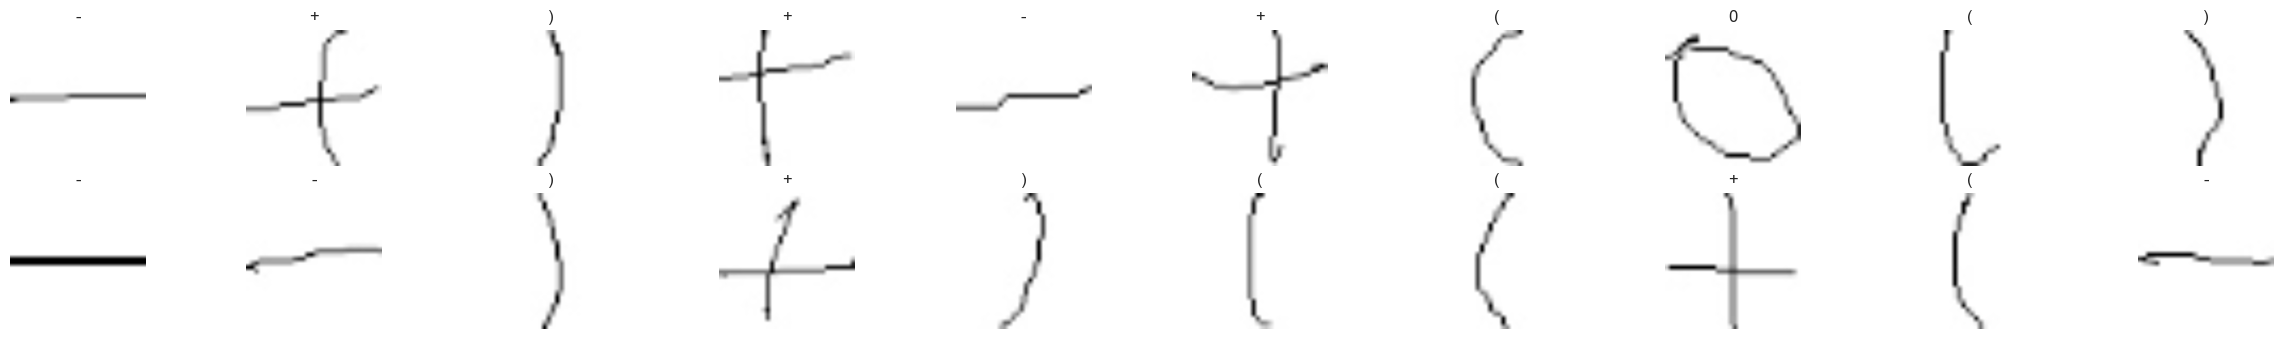

In [8]:
showImage(imagesTrainData,imagesTrainLabel, range(20))

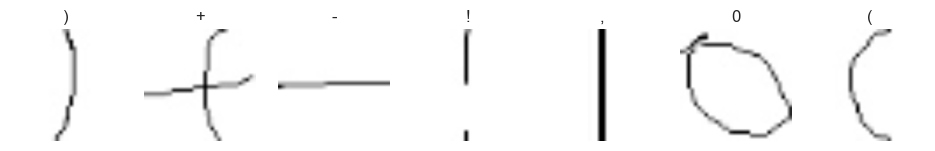

In [9]:
unique_idx = [imagesTrainLabel.index(i) for i in list(set(imagesTrainLabel))]
showImage(imagesTrainData,imagesTrainLabel, unique_idx )

### Visualizing the Distribution of Images

c:\Users\aryap\anaconda3\envs\Tensorflow\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


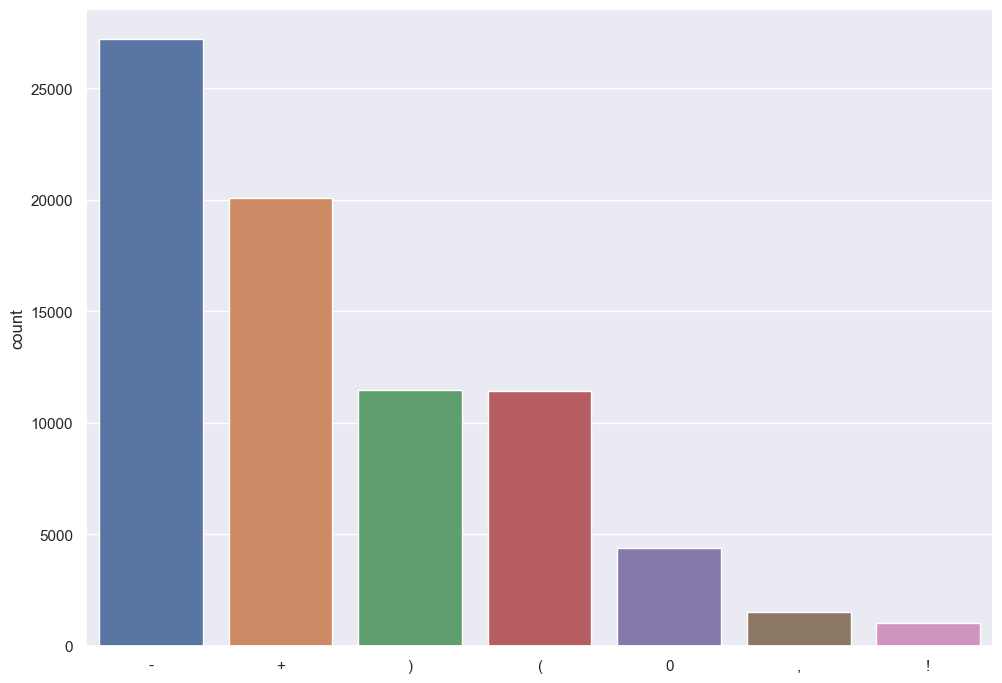

In [10]:
sns.countplot(x= list(imagesTrainLabel));

we can see data nearly balanced

---
# Preprocessing


### Encoding

In [11]:
label_encoder = LabelEncoder()
Y_train = label_encoder.fit_transform(imagesTrainLabel)
Y_test = label_encoder.transform(imagesTestLabel)

In [12]:
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

### Scaling

In [ ]:
X_train = np.array(imagesTrainData)
X_test = np.array(imagesTestData)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_train = X_train/255.
X_test = X_test/255.

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

In [ ]:
X_train[0].shape

---
# CNN Model

In [ ]:
def facial_recognition_detect_mood(input_shape=(32, 32, 1)):
   
    
    model = Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(7, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.0001,), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [ ]:
model = facial_recognition_detect_mood()
model.summary()

In [ ]:
def step_decay(epoch):
    initial_learning_rate = 0.001
    dropEvery = 10
    factor = 0.5
    lr = initial_learning_rate*(factor**np.floor((1 + epoch)/dropEvery))
    return float(lr)

checkpoint = ModelCheckpoint('HandwrittenMathEquationModel.h5', 
                             monitor='val_accuracy', 
                             save_best_only=True, 
                             verbose=1, 
                             mode='min')

earlyStopping = EarlyStopping(monitor='val_accuracy', 
                              mode='auto', 
                              verbose=1, 
                              patience=10, 
                              restore_best_weights=True)

reduceLr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)

callbacks = [checkpoint,earlyStopping,reduceLr, LearningRateScheduler(step_decay)]

In [ ]:
# Image Augmentation 
aug = ImageDataGenerator(zoom_range=0.1,
                         rotation_range=5,
                         width_shift_range=0.05,
                         height_shift_range=0.05)

In [ ]:
hist = model.fit(aug.flow(X_train, Y_train, batch_size=64), batch_size=64, epochs=90, validation_data=(X_test, Y_test), callbacks=callbacks)

In [ ]:
tf.keras.Model.save(model, filepath='my_model.keras')

In [ ]:
model.save('HandwrittenMathEquationModel.h5')

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Model Evaluation¶

In [ ]:
train_loss, train_accu = model.evaluate(X_train, Y_train)
test_loss, test_accu = model.evaluate(X_test, Y_test)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

> **Excellent accuracy is achieved on training set and  validation set 💪**

### Confusion Matrix and Classification on training set

In [ ]:
def confusion_mat(X, y):
    y_pred = model.predict(X)
    y_pred = np.argmax(y_pred, axis=1)
    y_target = np.argmax(y, axis=1)
    target_names = label_encoder.classes_
    
    print('Classification Report')
    target_names = label_encoder.classes_
    print(classification_report(y_target, y_pred, target_names=target_names))
    
    print('Confusion Matrix')
    cm_train = confusion_matrix(y_target , y_pred)
    print(cm_train)
    
    plt.figure(figsize=(5,5))
    plt.imshow(cm_train, interpolation='nearest')
    plt.colorbar()
    tick_mark = np.arange(len(target_names))
    _ = plt.xticks(tick_mark, target_names, rotation=90)
    _ = plt.yticks(tick_mark, target_names)

In [ ]:
# Train Set
confusion_mat(X_train,Y_train)

In [ ]:
# Test Set
confusion_mat(X_test,Y_test)

---
# Test the model


In [ ]:
# Get test image
image = cv2.imread('Img_Folder/-/-_66.jpg',cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(2, 2))
plt.imshow(image,cmap='gray')
plt.show()

In [ ]:
def image_preprocessing(image):
    image = cv2.resize(image, (32, 32))
    arrim = np.array(image)
    arrim = np.expand_dims(arrim, axis=-1)
    arrim = arrim/255.
    arrim = np.array([np.array(arrim)])
    return arrim

In [ ]:
# Make a prediction
prediction = model.predict(image_preprocessing(image))
prediction

In [ ]:
label_encoder.classes_[np.argmax(prediction)]

In [18]:
label_encoder.classes_

array(['!', '(', ')', '+', ',', '-', '0'], dtype='<U1')

In [ ]:
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt

def process_image(image_path, model):
    # Constants
    MIN_WIDTH = 20
    MIN_HEIGHT = 30

    chars = []
    img = cv2.imread(image_path)
    img = cv2.resize(img, (800, 800))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    edged = cv2.Canny(img_gray, 30, 150)
    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = imutils.sort_contours(contours, method="left-to-right")[0]
    
    labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'add', 'div', 'mul', 'sub']

    for c in contours:
        (x, y, w, h) = cv2.boundingRect(c)
        if w >= MIN_WIDTH and h >= MIN_HEIGHT:
            roi = img_gray[y:y+h, x:x+w]
            thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            (th, tw) = thresh.shape

            if tw > th:
                thresh = imutils.resize(thresh, width=32)
            if th > tw:
                thresh = imutils.resize(thresh, height=32)

            (th, tw) = thresh.shape
            dx = int(max(0, 32 - tw) / 2.0)
            dy = int(max(0, 32 - th) / 2.0)
            padded = cv2.copyMakeBorder(thresh, top=dy, bottom=dy, left=dx, right=dx, borderType=cv2.BORDER_CONSTANT, value=(0, 0, 0))
            padded = cv2.resize(padded, (32, 32))
            
            # Image preprocessing as requested
            arrim = np.array(padded)
            arrim = np.expand_dims(arrim, axis=-1)
            arrim = arrim / 255.
            arrim = np.array([np.array(arrim)])
            
            pred = model.predict(arrim)
            pred = np.argmax(pred, axis=1)

            label = labels[pred[0]]
            chars.append(label)

            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
            cv2.putText(img, label, (x-5, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

    # Display the image
    figure = plt.figure(figsize=(10, 10))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    expression = ''.join(['+' if i == 'add' else '-' if i == 'sub' else '*' if i == 'mul' else '/' if i == 'div' else i for i in chars])
    result = eval(expression)
    
    print('Value of the expression {}: {}'.format(expression, result))

# Example usage:
# model = your_model  # Make sure to provide the model you're


In [ ]:
test_pipeline_equation("/kaggle/working/data/test_equation4.jpg")